In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load dataset
df = pd.read_csv("weatherAUS.csv")

In [3]:
# Drop rows with missing target and missing rain today
df.dropna(subset=['RainTomorrow'], inplace=True)
df.dropna(subset=['RainToday'], inplace=True)

In [4]:
# Drop columns with more than 40% missing values
High_Missing_percentage = df.isnull().mean()
columns_to_drop = High_Missing_percentage[High_Missing_percentage > 0.4].index.tolist()
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Impute numerical with median
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = SimpleImputer(strategy='median').fit_transform(df[numeric_columns])

categorical_cols = df.select_dtypes(include=['object']).columns.drop('Date')
df[categorical_cols] = df[categorical_cols].fillna(method='ffill')

/var/folders/68/ym_p7n0x6sq1npn90ymtsxdw0000gn/T/ipykernel_9157/2791234806.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[categorical_cols] = df[categorical_cols].fillna(method='ffill')


In [6]:
# Encode the directional features such as 'WindGustDir', 'WindGustDir9am', and 'WindGustDir3pm' using cyclical encoding
def Cyclical_Encoding(series):
#directions to degrees mapping
    DirectionsToDegrees = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
        'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    #convert degrees to radians to apply sin and cosine calculations
    Radians = series.map(DirectionsToDegrees).fillna(0) * np.pi / 180
    return np.sin(Radians), np.cos(Radians)

for columns in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[f'{columns}_sin'], df[f'{columns}_cos'] = Cyclical_Encoding(df[columns])

In [7]:
# Encode the rain today and rain tomorrow features using binary encoding
df['RainToday_binary'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow_binary'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

In [8]:
# Encode the location feature using one-hot encoding
df = pd.get_dummies(df, columns=['Location'], prefix='Loca_')

In [9]:
# Drop Date column
df.drop(columns=['Date'], inplace=True)

In [10]:
# Preparing the data (after encoding all to numeric)
df_encoded = df.select_dtypes(include=[np.number])

In [11]:
# Outlier removal using IQR
numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop('RainTomorrow_binary')
Q1 = df_encoded[numeric_columns].quantile(0.25)
Q3 = df_encoded[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
Lower_limit = Q1 - 1.5*IQR
Upper_limit = Q3 + 1.5*IQR
df_final = df_encoded[~((df_encoded[numeric_columns] < (Lower_limit)) | (df_encoded[numeric_columns] > (Upper_limit))).any(axis=1)]

In [12]:
# Split features and target
X = df_final.drop(columns='RainTomorrow_binary')
Y = df_final['RainTomorrow_binary']

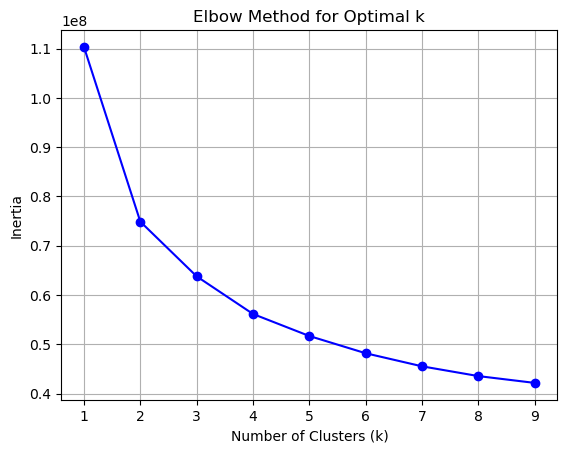

In [34]:
#Elbow Point
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Combine x and y into a 2D array
data = np.column_stack((X, Y))

# List to store inertia values
inertias = []

# Try different values of k (number of clusters)
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)  # Sum of squared distances

# Plot the elbow curve
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [13]:
#K-fold cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC

In [14]:
svm_classifier = SVC(kernel='linear')

In [35]:
num_folds = 4
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [36]:
cross_val_results = cross_val_score(svm_classifier, X, Y, cv=kf)

In [37]:
print("Cross-Validation Results (Accuracy):")
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")
    
print(f'Mean Accuracy: {cross_val_results.mean()* 100:.2f}%')

Cross-Validation Results (Accuracy):
  Fold 1: 87.38%
  Fold 2: 86.71%
  Fold 3: 86.86%
  Fold 4: 87.53%
Mean Accuracy: 87.12%
